In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

2023-01-29 09:02:23.994502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-29 09:02:31.010328: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/inte

In [2]:
df = pd.read_csv("/mnt/waterchallenge/MainData/00_all_ClimateIndices_and_precip.csv")
df.index = pd.to_datetime(df['date'])

<AxesSubplot: xlabel='date'>

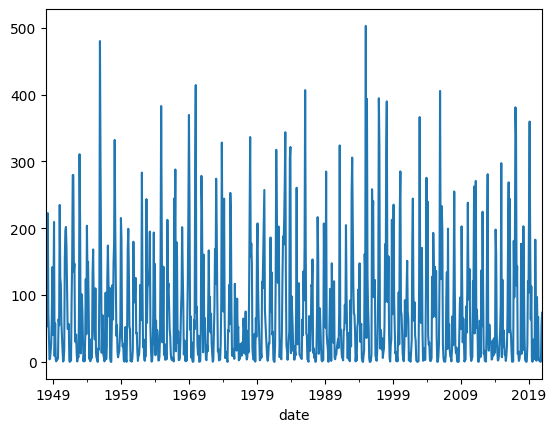

In [3]:
rainfall = df['precipitation']
rainfall.plot()

In [4]:
# Every 5 months try to predict the next month
# [[[1], [2], [3], [4], [5]]] [6] (jan feb march april may) (predict june)
# [[[2], [3], [4], [5], [6]]] [7] (feb march april may june) (predict july)
# etc...

# X is the 3d tensor (matrix), y is the prediction
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [5]:
# Split into sliding windows of WINDOW_SIZE samples with the WINDOW_SIZE + 1 as the label
WINDOW_SIZE = 5
X, y = df_to_X_y(rainfall, WINDOW_SIZE)
X.shape, y.shape

((871, 5, 1), (871,))

In [6]:
# Split into training, values, and testing
X_train1, y_train1 = X[:700], y[:700]
X_val1, y_val1 = X[700:788], y[700:788]
X_test1, y_test1 = X[788:], y[788:]

X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((700, 5, 1), (700,), (88, 5, 1), (88,), (83, 5, 1), (83,))

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Create first model

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

2023-01-29 09:02:36.348603: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-29 09:02:36.348680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zeusboost-dsvm): /proc/driver/nvidia/version does not exist
2023-01-29 09:02:36.350250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [77]:
# Save best model
cp = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [78]:
# Fit the model (only save model if validation loss is small)
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp])

Epoch 1/10
15/22 [===================>..........] - ETA: 0s - loss: 11785.9336 - root_mean_squared_error: 108.5630 

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


22/22 [==============================] - 7s 219ms/step - loss: 10943.6904 - root_mean_squared_error: 104.6121 - val_loss: 5525.2212 - val_root_mean_squared_error: 74.3318
Epoch 2/10
15/22 [===================>..........] - ETA: 0s - loss: 8758.9482 - root_mean_squared_error: 93.5893

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


22/22 [==============================] - 4s 195ms/step - loss: 8049.1851 - root_mean_squared_error: 89.7172 - val_loss: 5271.9331 - val_root_mean_squared_error: 72.6081
Epoch 3/10
15/22 [===================>..........] - ETA: 0s - loss: 8106.2085 - root_mean_squared_error: 90.0345

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


22/22 [==============================] - 5s 237ms/step - loss: 7583.0820 - root_mean_squared_error: 87.0809 - val_loss: 5076.0747 - val_root_mean_squared_error: 71.2466
Epoch 4/10
15/22 [===================>..........] - ETA: 0s - loss: 7874.2358 - root_mean_squared_error: 88.7369

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


22/22 [==============================] - 4s 195ms/step - loss: 7126.1558 - root_mean_squared_error: 84.4166 - val_loss: 4343.9346 - val_root_mean_squared_error: 65.9085
Epoch 5/10
14/22 [==================>...........] - ETA: 0s - loss: 6826.9526 - root_mean_squared_error: 82.6254

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


22/22 [==============================] - 4s 202ms/step - loss: 6285.5898 - root_mean_squared_error: 79.2817 - val_loss: 4180.4019 - val_root_mean_squared_error: 64.6560
Epoch 6/10
11/22 [==============>...............] - ETA: 0s - loss: 5716.3833 - root_mean_squared_error: 75.6068

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


22/22 [==============================] - 5s 241ms/step - loss: 5662.0640 - root_mean_squared_error: 75.2467 - val_loss: 4086.1736 - val_root_mean_squared_error: 63.9232
Epoch 7/10
15/22 [===================>..........] - ETA: 0s - loss: 5572.7935 - root_mean_squared_error: 74.6511

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


22/22 [==============================] - 4s 200ms/step - loss: 5387.2598 - root_mean_squared_error: 73.3980 - val_loss: 4055.6882 - val_root_mean_squared_error: 63.6843
Epoch 8/10
22/22 [==============================] - 0s 6ms/step - loss: 5287.7974 - root_mean_squared_error: 72.7172 - val_loss: 4103.3701 - val_root_mean_squared_error: 64.0576
Epoch 9/10
22/22 [==============================] - 0s 6ms/step - loss: 5140.6685 - root_mean_squared_error: 71.6985 - val_loss: 4214.4380 - val_root_mean_squared_error: 64.9187
Epoch 10/10
22/22 [==============================] - 0s 6ms/step - loss: 5036.0112 - root_mean_squared_error: 70.9649 - val_loss: 4448.4146 - val_root_mean_squared_error: 66.6964


In [10]:
# Load model from disk
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

# Quickly plot and show prediction vs actual data
def plot_predictions1(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    plt.show()
    return df, mse(y, predictions)

22/22 [==============================] - 0s 2ms/step


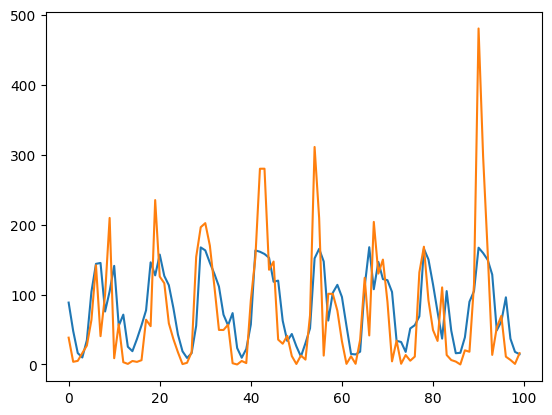

3/3 [==============================] - 0s 3ms/step


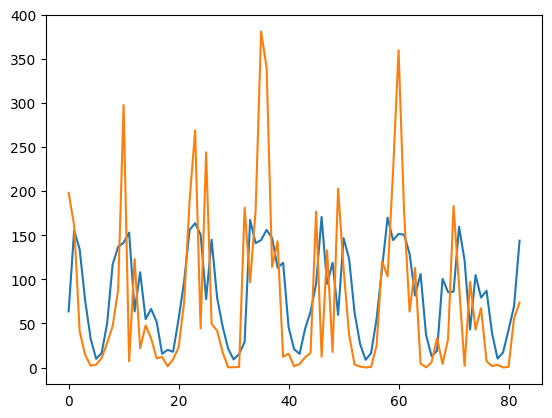

(    Predictions   Actuals
 0     63.679890  198.0503
 1    155.464081  161.3026
 2    134.227173   41.2507
 3     76.190155   14.4935
 4     32.768894    2.0898
 ..          ...       ...
 78    10.205628    3.2309
 79    17.150961    0.1364
 80    42.647808    0.8095
 81    69.651947   55.8867
 82   143.804977   73.7052
 
 [83 rows x 2 columns],
 6185.34986529332)

In [80]:
plot_predictions1(model1, X_train1, y_train1)
plot_predictions1(model1, X_test1, y_test1)

In [73]:
# Create second model (1D CNN)

model2 = Sequential()
model2.add(InputLayer((WINDOW_SIZE, 1)))
model2.add(Conv1D(64, kernel_size=2)) # Slide kernel across window size 5 and turn 2 values into 1
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 4, 64)             192       
                                                                 
 flatten_3 (Flatten)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 8)                 2056      
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [74]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [75]:
# Fit the model (only save model if validation loss is small)
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2])

Epoch 1/10
 1/22 [>.............................] - ETA: 14s - loss: 18958.3203 - root_mean_squared_error: 137.6892

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


22/22 [==============================] - 2s 45ms/step - loss: 11699.1416 - root_mean_squared_error: 108.1626 - val_loss: 7390.1646 - val_root_mean_squared_error: 85.9661
Epoch 2/10
 1/22 [>.............................] - ETA: 0s - loss: 11170.2754 - root_mean_squared_error: 105.6895

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


22/22 [==============================] - 1s 34ms/step - loss: 10099.7754 - root_mean_squared_error: 100.4976 - val_loss: 6503.1973 - val_root_mean_squared_error: 80.6424
Epoch 3/10
 1/22 [>.............................] - ETA: 0s - loss: 10134.0801 - root_mean_squared_error: 100.6682

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


22/22 [==============================] - 1s 37ms/step - loss: 9049.7344 - root_mean_squared_error: 95.1301 - val_loss: 6037.5156 - val_root_mean_squared_error: 77.7015
Epoch 4/10
 1/22 [>.............................] - ETA: 0s - loss: 13844.2891 - root_mean_squared_error: 117.6618

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


22/22 [==============================] - 1s 35ms/step - loss: 8611.8926 - root_mean_squared_error: 92.8003 - val_loss: 5808.0303 - val_root_mean_squared_error: 76.2104
Epoch 5/10
 1/22 [>.............................] - ETA: 0s - loss: 3418.5107 - root_mean_squared_error: 58.4680

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


22/22 [==============================] - 1s 46ms/step - loss: 8315.6084 - root_mean_squared_error: 91.1900 - val_loss: 5692.6353 - val_root_mean_squared_error: 75.4496
Epoch 6/10
 1/22 [>.............................] - ETA: 0s - loss: 13415.3945 - root_mean_squared_error: 115.8248

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


22/22 [==============================] - 1s 35ms/step - loss: 8102.2700 - root_mean_squared_error: 90.0126 - val_loss: 5604.1187 - val_root_mean_squared_error: 74.8607
Epoch 7/10
 1/22 [>.............................] - ETA: 0s - loss: 3164.5674 - root_mean_squared_error: 56.2545

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


22/22 [==============================] - 1s 35ms/step - loss: 7921.0122 - root_mean_squared_error: 89.0001 - val_loss: 5542.1221 - val_root_mean_squared_error: 74.4454
Epoch 8/10
 1/22 [>.............................] - ETA: 0s - loss: 6302.4482 - root_mean_squared_error: 79.3880

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


22/22 [==============================] - 1s 38ms/step - loss: 7778.3267 - root_mean_squared_error: 88.1948 - val_loss: 5489.2471 - val_root_mean_squared_error: 74.0895
Epoch 9/10
20/22 [==========================>...] - ETA: 0s - loss: 7635.0811 - root_mean_squared_error: 87.3790

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


22/22 [==============================] - 1s 67ms/step - loss: 7655.5444 - root_mean_squared_error: 87.4960 - val_loss: 5456.8887 - val_root_mean_squared_error: 73.8708
Epoch 10/10
10/22 [============>.................] - ETA: 0s - loss: 7234.5796 - root_mean_squared_error: 85.0563

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


22/22 [==============================] - 1s 42ms/step - loss: 7551.7319 - root_mean_squared_error: 86.9007 - val_loss: 5430.0278 - val_root_mean_squared_error: 73.6887


22/22 [==============================] - 0s 2ms/step


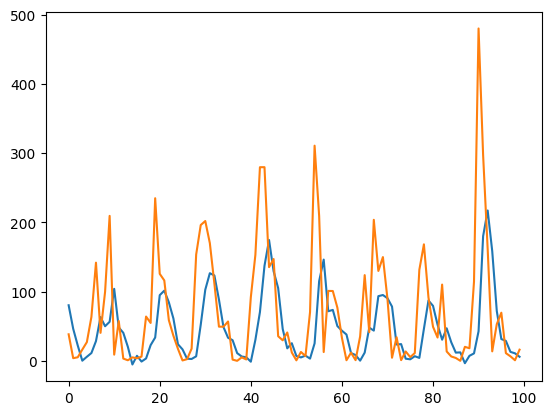

3/3 [==============================] - 0s 2ms/step


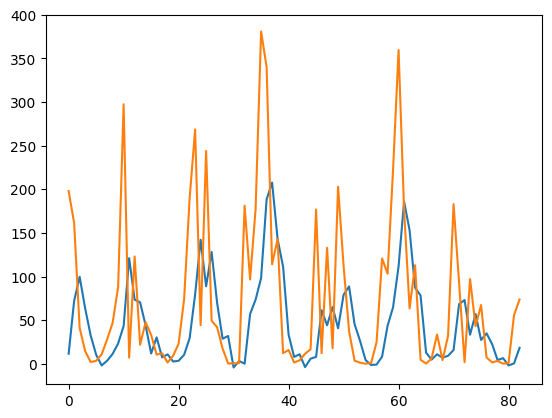

(    Predictions   Actuals
 0     11.515946  198.0503
 1     72.097626  161.3026
 2     99.733276   41.2507
 3     63.669022   14.4935
 4     32.566105    2.0898
 ..          ...       ...
 78     4.337388    3.2309
 79     6.464145    0.1364
 80    -1.912099    0.8095
 81     0.441171   55.8867
 82    18.324392   73.7052
 
 [83 rows x 2 columns],
 7875.582705904811)

In [76]:
plot_predictions1(model2, X_train1, y_train1)
plot_predictions1(model2, X_test1, y_test1)

In [29]:
# Create second model (1D CNN)

model3 = Sequential()
model3.add(InputLayer((WINDOW_SIZE, 1)))
model3.add(GRU(64)) # Slide kernel across window size 5 and turn 2 values into 1
model3.add(Flatten())
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [30]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [31]:
# Fit the model (only save model if validation loss is small)
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp3])

Epoch 1/10
14/22 [==================>...........] - ETA: 0s - loss: 13441.9297 - root_mean_squared_error: 115.9393 

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


22/22 [==============================] - 6s 199ms/step - loss: 13550.7188 - root_mean_squared_error: 116.4076 - val_loss: 9042.7217 - val_root_mean_squared_error: 95.0932
Epoch 2/10
13/22 [================>.............] - ETA: 0s - loss: 14473.2656 - root_mean_squared_error: 120.3049

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


22/22 [==============================] - 4s 207ms/step - loss: 13526.4014 - root_mean_squared_error: 116.3031 - val_loss: 9026.1943 - val_root_mean_squared_error: 95.0063
Epoch 3/10
15/22 [===================>..........] - ETA: 0s - loss: 13046.9287 - root_mean_squared_error: 114.2232

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


22/22 [==============================] - 4s 178ms/step - loss: 13507.8604 - root_mean_squared_error: 116.2233 - val_loss: 9014.6836 - val_root_mean_squared_error: 94.9457
Epoch 4/10
22/22 [==============================] - ETA: 0s - loss: 13496.0381 - root_mean_squared_error: 116.1724

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


22/22 [==============================] - 4s 212ms/step - loss: 13496.0381 - root_mean_squared_error: 116.1724 - val_loss: 9006.7666 - val_root_mean_squared_error: 94.9040
Epoch 5/10
14/22 [==================>...........] - ETA: 0s - loss: 12690.9062 - root_mean_squared_error: 112.6539

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


22/22 [==============================] - 4s 198ms/step - loss: 13486.9619 - root_mean_squared_error: 116.1334 - val_loss: 8999.2510 - val_root_mean_squared_error: 94.8644
Epoch 6/10
13/22 [================>.............] - ETA: 0s - loss: 14529.3633 - root_mean_squared_error: 120.5378

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


22/22 [==============================] - 4s 178ms/step - loss: 13477.8262 - root_mean_squared_error: 116.0940 - val_loss: 8991.2090 - val_root_mean_squared_error: 94.8220
Epoch 7/10
13/22 [================>.............] - ETA: 0s - loss: 14644.6367 - root_mean_squared_error: 121.0150

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


22/22 [==============================] - 5s 218ms/step - loss: 13467.8047 - root_mean_squared_error: 116.0509 - val_loss: 8982.3135 - val_root_mean_squared_error: 94.7751
Epoch 8/10
15/22 [===================>..........] - ETA: 0s - loss: 14119.3018 - root_mean_squared_error: 118.8247

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


22/22 [==============================] - 4s 178ms/step - loss: 13456.4961 - root_mean_squared_error: 116.0021 - val_loss: 8971.8994 - val_root_mean_squared_error: 94.7201
Epoch 9/10
11/22 [==============>...............] - ETA: 0s - loss: 13299.1787 - root_mean_squared_error: 115.3221

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


22/22 [==============================] - 4s 209ms/step - loss: 13442.4785 - root_mean_squared_error: 115.9417 - val_loss: 8958.6631 - val_root_mean_squared_error: 94.6502
Epoch 10/10
14/22 [==================>...........] - ETA: 0s - loss: 14184.7529 - root_mean_squared_error: 119.0998

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


22/22 [==============================] - 4s 177ms/step - loss: 13425.3770 - root_mean_squared_error: 115.8679 - val_loss: 8940.9395 - val_root_mean_squared_error: 94.5565


22/22 [==============================] - 1s 2ms/step


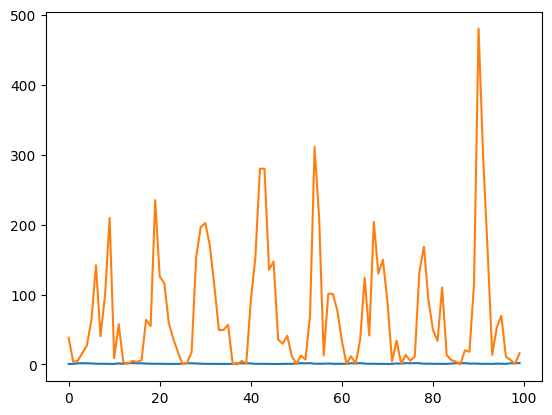

3/3 [==============================] - 0s 3ms/step


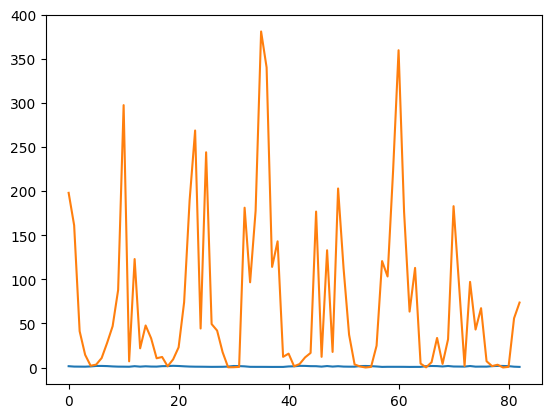

(    Predictions   Actuals
 0      1.570859  198.0503
 1      1.136317  161.3026
 2      1.083659   41.2507
 3      1.034352   14.4935
 4      1.318486    2.0898
 ..          ...       ...
 78     1.901279    3.2309
 79     1.830161    0.1364
 80     1.641130    0.8095
 81     1.017110   55.8867
 82     0.781747   73.7052
 
 [83 rows x 2 columns],
 13831.283937257145)

In [32]:
plot_predictions1(model3, X_train1, y_train1)
plot_predictions1(model3, X_test1, y_test1)

In [36]:
temp_df = pd.DataFrame({'Precipitation':rainfall})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Precipitation,Seconds
date,,
1948-01-01,108.1699,-6.943104e+08
1948-02-01,52.6629,-6.916320e+08
1948-03-01,150.4337,-6.891264e+08
1948-04-01,222.6304,-6.864480e+08
1948-05-01,72.5689,-6.838560e+08
...,...,...
2020-08-01,3.2309,1.596240e+09
2020-09-01,0.1364,1.598918e+09
2020-10-01,0.8095,1.601510e+09


In [40]:
day = 60 * 60 * 24      # seconds in a day
year = 365.2425 * day   # seconds in a year

temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df.head()

,Precipitation,Seconds,Day sin,Day cos,Year sin,Year cos
date,,,,,,
1948-01-01,108.1699,-694310400.0,3.190386e-12,1.0,-0.011440,0.999935
1948-02-01,52.6629,-691632000.0,5.477846e-12,1.0,0.498481,0.866900
1948-03-01,150.4337,-689126400.0,-8.317710e-13,1.0,0.852488,0.522747
1948-04-01,222.6304,-686448000.0,1.455689e-12,1.0,0.999859,0.016783
1948-05-01,72.5689,-683856000.0,-5.553891e-13,1.0,0.877918,-0.478811


In [41]:
temp_df = temp_df.drop('Seconds', axis=1)
temp_df.head()

,Precipitation,Day sin,Day cos,Year sin,Year cos
date,,,,,
1948-01-01,108.1699,3.190386e-12,1.0,-0.011440,0.999935
1948-02-01,52.6629,5.477846e-12,1.0,0.498481,0.866900
1948-03-01,150.4337,-8.317710e-13,1.0,0.852488,0.522747
1948-04-01,222.6304,1.455689e-12,1.0,0.999859,0.016783
1948-05-01,72.5689,-5.553891e-13,1.0,0.877918,-0.478811


In [42]:
# Every 5 months try to predict the next month
# [[[p1, ds1, ... (all features)], [p2, ds2], [p3, ds3], [p4, ds4], [p5, ds5]]] [p6] 
# [[[p2, ds2], [p3, ds3], [p4, ds4], [p5, ds5], [p6, ds6]]] [p7]
# etc...

# X is the 3d tensor (matrix), y is the prediction
def df_to_X_y2(df, window_size=6):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [43]:
# Create tensors
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape

((870, 6, 5), (870,))

In [45]:
# Split into training, values, and testing
X_train2, y_train2 = X2[:700], y2[:700]
X_val2, y_val2 = X2[700:788], y2[700:788]
X_test2, y_test2 = X2[788:], y2[788:]

X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((700, 6, 5), (700,), (88, 6, 5), (88,), (82, 6, 5), (82,))

In [46]:
# need to scale all values to relative numbers (so large numbers don't overpower small numbers)
temp_training_mean = np.mean(X_train2[:, :, 0])
temp_training_std = np.std(X_train2[:, :, 0])

def preprocess(X):
    X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
    return X

In [47]:
preprocess(X_train2)
preprocess(X_val2)
preprocess(X_test2)

array([[[-5.00102859e-01, -1.12320740e-11,  1.00000000e+00,
         -8.66691242e-01, -4.98844958e-01],
        [-7.55278549e-01,  1.30876287e-12,  1.00000000e+00,
         -9.99980890e-01, -6.18220863e-03],
        [-4.62536389e-01, -1.09556921e-11,  1.00000000e+00,
         -8.64267555e-01,  5.03032398e-01],
        [-7.16518200e-01,  1.58514470e-12,  1.00000000e+00,
         -5.03469076e-01,  8.64013246e-01],
        [-6.23015811e-01, -1.06793103e-11,  1.00000000e+00,
          5.67688594e-03,  9.99983886e-01],
        [ 1.37639933e+00, -8.39185008e-12,  1.00000000e+00,
          5.13246277e-01,  8.58241376e-01]],

       [[-7.55278549e-01,  1.30876287e-12,  1.00000000e+00,
         -9.99980890e-01, -6.18220863e-03],
        [-4.62536389e-01, -1.09556921e-11,  1.00000000e+00,
         -8.64267555e-01,  5.03032398e-01],
        [-7.16518200e-01,  1.58514470e-12,  1.00000000e+00,
         -5.03469076e-01,  8.64013246e-01],
        [-6.23015811e-01, -1.06793103e-11,  1.00000000e+00,
  

In [48]:
# Multivariate LSTM

model4 = Sequential()
model4.add(InputLayer((6, 5)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


In [49]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [50]:
# Fit the model (only save model if validation loss is small)
model4.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=10, callbacks=[cp4])

Epoch 1/10
13/22 [================>.............] - ETA: 0s - loss: 13417.8066 - root_mean_squared_error: 115.8353 

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 7s 244ms/step - loss: 13577.4883 - root_mean_squared_error: 116.5225 - val_loss: 9518.5947 - val_root_mean_squared_error: 97.5633
Epoch 2/10
13/22 [================>.............] - ETA: 0s - loss: 13845.8613 - root_mean_squared_error: 117.6684

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 4s 193ms/step - loss: 13572.9658 - root_mean_squared_error: 116.5031 - val_loss: 9516.4102 - val_root_mean_squared_error: 97.5521
Epoch 3/10
13/22 [================>.............] - ETA: 0s - loss: 12986.6943 - root_mean_squared_error: 113.9592

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 5s 226ms/step - loss: 13570.2256 - root_mean_squared_error: 116.4913 - val_loss: 9515.4209 - val_root_mean_squared_error: 97.5470
Epoch 4/10
14/22 [==================>...........] - ETA: 0s - loss: 13357.8643 - root_mean_squared_error: 115.5762

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 4s 200ms/step - loss: 13568.7373 - root_mean_squared_error: 116.4849 - val_loss: 9514.7500 - val_root_mean_squared_error: 97.5436
Epoch 5/10
15/22 [===================>..........] - ETA: 0s - loss: 13325.3857 - root_mean_squared_error: 115.4356

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 4s 195ms/step - loss: 13567.6689 - root_mean_squared_error: 116.4803 - val_loss: 9514.0508 - val_root_mean_squared_error: 97.5400
Epoch 6/10
14/22 [==================>...........] - ETA: 0s - loss: 13962.4854 - root_mean_squared_error: 118.1630

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 5s 232ms/step - loss: 13566.7002 - root_mean_squared_error: 116.4762 - val_loss: 9513.2344 - val_root_mean_squared_error: 97.5358
Epoch 7/10
14/22 [==================>...........] - ETA: 0s - loss: 13648.9561 - root_mean_squared_error: 116.8287

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 4s 187ms/step - loss: 13565.6182 - root_mean_squared_error: 116.4715 - val_loss: 9512.2422 - val_root_mean_squared_error: 97.5307
Epoch 8/10
13/22 [================>.............] - ETA: 0s - loss: 14564.5830 - root_mean_squared_error: 120.6838

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 5s 229ms/step - loss: 13564.3398 - root_mean_squared_error: 116.4660 - val_loss: 9511.0098 - val_root_mean_squared_error: 97.5244
Epoch 9/10
12/22 [===============>..............] - ETA: 0s - loss: 14238.8594 - root_mean_squared_error: 119.3267

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 4s 193ms/step - loss: 13562.7197 - root_mean_squared_error: 116.4591 - val_loss: 9509.4785 - val_root_mean_squared_error: 97.5166
Epoch 10/10
13/22 [================>.............] - ETA: 0s - loss: 14352.4062 - root_mean_squared_error: 119.8015

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 4s 195ms/step - loss: 13560.6885 - root_mean_squared_error: 116.4504 - val_loss: 9507.4365 - val_root_mean_squared_error: 97.5061


3/3 [==============================] - 0s 4ms/step


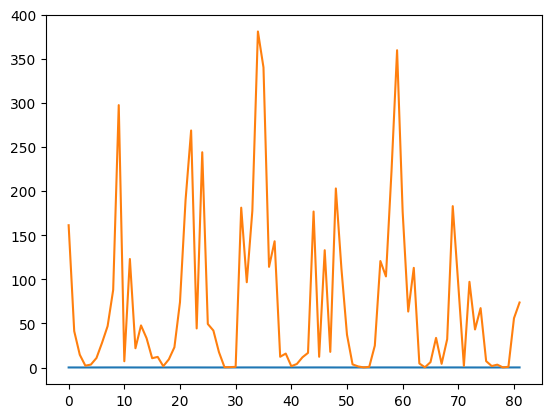

(    Predictions   Actuals
 0      0.063820  161.3026
 1      0.055555   41.2507
 2      0.046896   14.4935
 3      0.045008    2.0898
 4      0.047890    3.3410
 ..          ...       ...
 77     0.059668    3.2309
 78     0.069256    0.1364
 79     0.079503    0.8095
 80     0.085399   55.8867
 81     0.087666   73.7052
 
 [82 rows x 2 columns],
 13673.789408832443)

In [51]:
plot_predictions1(model4, X_test2, y_test2)